## Import library

In [1]:
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF
import torchmetrics

import numpy as np
import pandas as pd

import albumentations
import albumentations.pytorch
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from PIL import Image
from tqdm import tqdm

## Download dataset

In [2]:
# import kaggle
# kaggle.api.authenticate()
# kaggle.api.dataset_download_files('sorour/38cloud-cloud-segmentation-in-satellite-images', path='dataset', unzip=True)

## Configurations

In [3]:
!nvidia-smi

Thu Dec  1 18:39:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:04:00.0 Off |                  N/A |
| 41%   40C    P8    25W / 260W |      3MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:05:00.0 Off |                  N/A |
| 40%   

In [4]:
BASE_DIR = 'dataset'
TRAIN_DIR = f'{BASE_DIR}/38-Cloud_training'
TEST_DIR = f'{BASE_DIR}/38-Cloud_test'
TRAIN_PATCHES_FILE = f'{BASE_DIR}/training_patches_38-cloud_nonempty.csv'
TEST_PATCHES_FILE = f'{TEST_DIR}/test_patches_38-Cloud.csv'
BATCH_SIZE = 12
NUM_EPOCHS = 20
LOW_TRAINABLE_THRESHOLD = 0.03
HIGH_TRAINABLE_THRESHOLD = 0.97
LEARNING_RATE = 1e-4
torch.manual_seed(42)
torch.cuda.is_available()

True

In [5]:
torch.cuda.set_device(7)
print(torch.cuda.current_device())

7


## Import Dataset

In [6]:
class CreateCloudDataset():
    def __init__(self):
        self.transform = albumentations.Compose([
            albumentations.Normalize(mean=[0.0], std=[1.0], max_pixel_value=65535.0),
            albumentations.Resize(192, 192),
            albumentations.pytorch.ToTensorV2()
        ])
        self.train_patches = pd.read_csv(TRAIN_PATCHES_FILE)
        self.test_patches = pd.read_csv(TEST_PATCHES_FILE)

    def import_dataset(self, patches, is_train):
        if is_train:
            bands = ['nir', 'red', 'green', 'blue', 'gt']
            bands_path = [f"{TRAIN_DIR}/train_{x}/{x}_" for x in bands]
        else:
            bands = ['nir', 'red', 'green', 'blue']
            bands_path = [f"{TEST_DIR}/test_{x}/{x}_" for x in bands]
            
        dataset = []
        ratio_non_zero_map = {}
        

        for i in tqdm(range(len(patches))):
            image_file_name = patches.iloc[i][0]
            bands_file_name = [f"{x}{image_file_name}.TIF" for x in bands_path]
            all_bands = []
            for x in bands_file_name:
                im = Image.open(x)
                image = np.array(im, dtype=np.float32)
                im.close()
                all_bands.append(self.transform(image=image)['image'])
            non_zero = torch.count_nonzero(all_bands[-1])
            ratio_non_zero = non_zero.item()/(192*192)
            
            rounded_ratio_non_zero = round(ratio_non_zero, 1)
            if rounded_ratio_non_zero not in ratio_non_zero_map:
                ratio_non_zero_map[rounded_ratio_non_zero] = 1
            else:
                ratio_non_zero_map[rounded_ratio_non_zero] += 1
            
            if ratio_non_zero < LOW_TRAINABLE_THRESHOLD or ratio_non_zero > HIGH_TRAINABLE_THRESHOLD:
                continue
            image = torch.cat((all_bands[0], all_bands[1], all_bands[2], all_bands[3]), dim=0)
            if is_train:
                label = all_bands[-1]
                label[label > 0] = 1.0
                dataset.append((image, label))
            else:
                dataset.append((image, image_file_name)) 
                
        ratio_non_zero_key = list(ratio_non_zero_map.keys())
        ratio_non_zero_val = list(ratio_non_zero_map.values())
        plt.bar(range(len(ratio_non_zero_map)), ratio_non_zero_val, tick_label=ratio_non_zero_key)
        plt.show()
        return dataset

class CloudTrainDataset():
    def __init__(self, dataset):
            self.dataset = dataset
            self.train_dataset, self.valid_dataset = self.split(train_ratio=0.8)
            self.train_dataset = self.create_batch(self.train_dataset, BATCH_SIZE, shuffle=True)
            self.valid_dataset = self.create_batch(self.valid_dataset, BATCH_SIZE, shuffle=False)
    
    def split(self, train_ratio):
            train_size = int(train_ratio * len(self.dataset))
            valid_size = len(self.dataset) - train_size
            return random_split(self.dataset, [train_size, valid_size])

    def create_batch(self, data, batch_size, shuffle):
            return DataLoader(data, batch_size=batch_size, shuffle=shuffle)
        
class CloudTestDataset():
    def __init__(self, dataset):
            self.dataset = dataset
            self.test_dataset = self.create_batch(self.test_dataset, BATCH_SIZE, shuffle=False)

    def create_batch(self, data, batch_size, shuffle):
            return DataLoader(data, batch_size=batch_size, shuffle=shuffle)  

100%|███████████████████████████████████████████████████████████████████████████████| 5155/5155 [02:19<00:00, 37.03it/s]


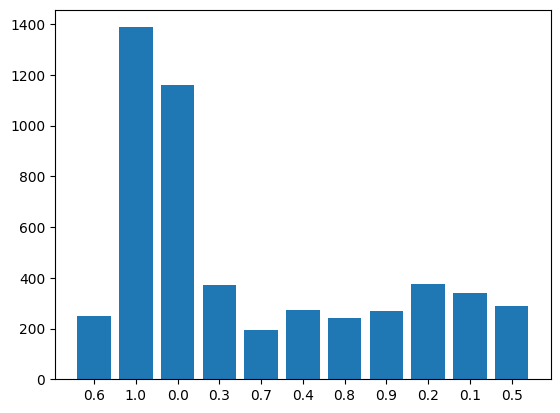

In [7]:
ds = CreateCloudDataset()
train_dataset = ds.import_dataset(ds.train_patches, is_train=True)

In [8]:
len(train_dataset)

2788

In [9]:
dataset = CloudTrainDataset(train_dataset)

## Preview Dataset

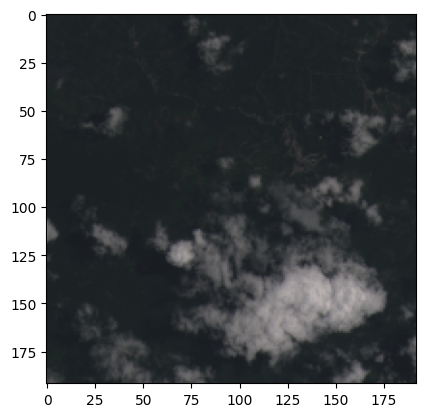

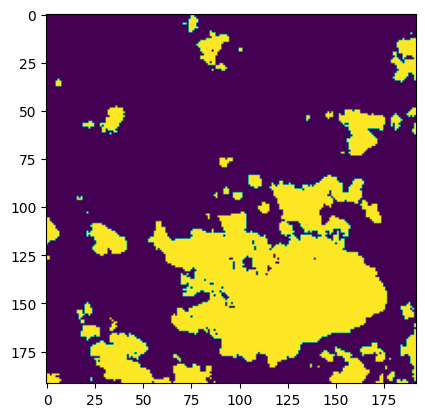

In [10]:
for img, label in dataset.train_dataset:
    img = img[0]
    label = label[0]
    img = np.dstack((img[1], img[2], img[3]))
    label = label.swapaxes(0,1).swapaxes(1,2)
    plt.imshow(img)
    plt.show()
    plt.imshow(label)
    plt.show()
    break

## Define Metrics

In [11]:
class Metrics():
    def __init__(self):
        self.loss = 0.0
        self.precision = 0.0
        self.recall = 0.0
        self.f1 = 0.0
        self.accuracy = 0.0
        self.iou = 0.0
        
    def avg_compute_fn(self, previous_metric_value, added_value, length):
        return (previous_metric_value * length + added_value) / (length+1)

    def compute_loss(self, loss, idx):
        self.loss = self.avg_compute_fn(self.loss, loss, idx)

    def compute_metrics(self, y_pred, y_true, idx):
        self.precision  = self.avg_compute_fn(self.precision, torchmetrics.functional.classification.binary_precision(y_pred, y_true).item(), idx)
        self.recall     = self.avg_compute_fn(self.recall, torchmetrics.functional.classification.binary_recall(y_pred, y_true).item(), idx)
        self.f1         = self.avg_compute_fn(self.f1, torchmetrics.functional.classification.binary_f1_score(y_pred, y_true).item(), idx)
        self.accuracy   = self.avg_compute_fn(self.accuracy, torchmetrics.functional.classification.binary_accuracy(y_pred, y_true).item(), idx)
        self.iou        = self.avg_compute_fn(self.iou, torchmetrics.functional.classification.binary_jaccard_index(y_pred, y_true).item(), idx)

    def print(self, type):
        print(f"[{type}] Loss: {self.loss:.4f},"
            f"   Precision: {self.precision:.4f},"
            f"   Recall: {self.recall:.4f},"
            f"   F1: {self.f1:.4f},"
            f"   Accuracy: {self.accuracy:.4f}," 
            f"   IoU: {self.iou:.4f}")

## Build Model

In [12]:
def fit(model, train_data, valid_data, loss_fn, optimizer):
    best_iou = 0.0
    best_metric = None
    for epoch in range(NUM_EPOCHS):
        loop = tqdm(train_data)
        metrics = Metrics()
        model.train()
        
        for idx, (images, labels) in enumerate(loop):
            images = images.cuda()
            labels = labels.cuda()
            predict = model(images)
            loss = loss_fn(predict, labels)
            metrics.compute_loss(loss.item(), idx)
            metrics.compute_metrics(predict, labels.int(), idx)
            loop.set_postfix(loss=metrics.loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"[Epoch] {epoch}")
        metrics.print("Train")

        with torch.no_grad():
            metrics = Metrics()
            model.eval()
            for idx, (images, labels) in enumerate(valid_data):
                images = images.cuda()
                labels = labels.cuda()
                predict = model(images)
                loss = loss_fn(predict, labels)
                metrics.compute_loss(loss.item(), idx)
                metrics.compute_metrics(predict, labels.int(), idx)
            metrics.print("Valid")
            
            if metrics.iou > best_iou:
                best_iou = metrics.iou
                best_metric = metrics
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss_fn,
                    }, 'checkpoint_cloudnet.pt')
    return metrics

In [13]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    def forward(self, x):
        return self.conv(x)
    
class TripleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TripleConv, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        
    def forward(self, x):
        x1 = self.double_conv(x)
        out = self.conv(x1)
        return (out, x1)
    
class DownBlockCopyLayer(nn.Module):
    def __init__(self, channels):
        super(DownBlockCopyLayer, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=1),
            nn.BatchNorm2d(channels),
            nn.ReLU()
        )
        self.bn_relu = nn.Sequential(
            nn.BatchNorm2d(channels*2),
            nn.ReLU()
        )
    
    def forward(self, x):
        copy_layer = x
        x = self.conv(x)
        x = torch.cat([x, copy_layer], dim=1)
        x = self.bn_relu(x)
        return x
        
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.copy_layer = DownBlockCopyLayer(in_channels)
        self.conv = DoubleConv(in_channels, out_channels)
        self.bn_relu = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        
    def forward(self, x):
        x1 = self.copy_layer(x)
        x2 = self.conv(x)
        x = self.bn_relu(x1 + x2)
        return x
    
class DownBlockLast(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlockLast, self).__init__()
        self.copy_layer = DownBlockCopyLayer(in_channels)
        self.conv = TripleConv(in_channels, out_channels)
        self.bn_relu = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        x1 = self.copy_layer(x)
        x2_final_out, x2_middle_out = self.conv(x)
        x = self.bn_relu(x1 + x2_middle_out + x2_final_out)
        return x

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.transposed = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv = DoubleConv(in_channels, out_channels)
        self.bn_relu = nn.Sequential(
            nn.BatchNorm2d(out_channels*2),
            nn.ReLU()
        )
        
        self.bn_relu_last = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        
    def forward(self, skip_connect, x):
        x = self.transposed(x)
        
        if x.shape != skip_connect.shape:
            x = TF.resize(x, size=skip_connect.shape[2:])
        x = torch.cat([skip_connect, x], dim=1)
        x = self.bn_relu(x)
        x = self.conv(x)
        x = x + skip_connect
        x = self.bn_relu_last(x)
        return x
        
class UpBlockFirst(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlockFirst, self).__init__()
        self.transposed = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv = TripleConv(in_channels, out_channels)
        self.bn_relu = nn.Sequential(
            nn.BatchNorm2d(out_channels*2),
            nn.ReLU()
        )
        
        self.bn_relu_last = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        
    def forward(self, skip_connect, x):
        x = self.transposed(x)
        
        if x.shape != skip_connect.shape:
            x = TF.resize(x, size=skip_connect.shape[2:])
            
        x = torch.cat([skip_connect, x], dim=1)
        x = self.bn_relu(x)
        x_final_out, x_middle_out = self.conv(x)
        x = x_final_out + skip_connect
        x = self.bn_relu_last(x)
        return x
    
class CloudNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CloudNet, self).__init__()
        
        self.first_conv = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        
        self.downs = nn.ModuleList([
            DownBlock(16, 32),
            DownBlock(32, 64),
            DownBlock(64, 128),
            DownBlock(128, 256),
            DownBlock(256, 512),
        ])
        self.bottle_neck = DownBlockLast(512, 1024)
        
        self.ups = nn.ModuleList([
            UpBlockFirst(1024, 512),
            UpBlock(512, 256),
            UpBlock(256, 128),
            UpBlock(128, 64),
            UpBlock(64, 32),
        ])
        
        self.final_conv = nn.Sequential(
            nn.Conv2d(32, 1, kernel_size=1,stride=1,padding=0),
            nn.Sigmoid()
        )
        
        self.pool = nn.MaxPool2d(2)
        
    def forward(self, x):
        x = self.first_conv(x)
        skip_layer = []
        
        for idx, down_layer in enumerate(self.downs):
            x = down_layer(x)
            skip_layer.append(x)
            x = self.pool(x)
            
        x = self.bottle_neck(x)
           
        skip_layer = skip_layer[::-1]
        for idx, up_layer in enumerate(self.ups):
            skip = skip_layer[idx]
            x = up_layer(skip, x)
            
        x = self.final_conv(x)
        return x     

## Train Model

In [14]:
model = CloudNet(in_channels=4, out_channels=1)
model = nn.DataParallel(model, device_ids = [7, 1])
model.cuda()
loss_fn = nn.BCELoss()
optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
best = fit(model, dataset.train_dataset, dataset.valid_dataset, loss_fn, optimizer)

100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:55<00:00,  3.36it/s, loss=0.476]


[Epoch] 0
[Train] Loss: 0.4757,   Precision: 0.8574,   Recall: 0.6322,   F1: 0.7115,   Accuracy: 0.7813,   IoU: 0.5703
[Valid] Loss: 0.3676,   Precision: 0.9025,   Recall: 0.7718,   F1: 0.8264,   Accuracy: 0.8631,   IoU: 0.7120


100%|██████████████████████████████████████████████████████████████████████| 186/186 [00:44<00:00,  4.22it/s, loss=0.37]


[Epoch] 1
[Train] Loss: 0.3700,   Precision: 0.8866,   Recall: 0.7943,   F1: 0.8328,   Accuracy: 0.8549,   IoU: 0.7171
[Valid] Loss: 0.3102,   Precision: 0.9107,   Recall: 0.8136,   F1: 0.8564,   Accuracy: 0.8824,   IoU: 0.7531


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:43<00:00,  4.32it/s, loss=0.333]


[Epoch] 2
[Train] Loss: 0.3329,   Precision: 0.8870,   Recall: 0.8282,   F1: 0.8532,   Accuracy: 0.8707,   IoU: 0.7467
[Valid] Loss: 0.2939,   Precision: 0.9277,   Recall: 0.8300,   F1: 0.8739,   Accuracy: 0.8962,   IoU: 0.7790


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:40<00:00,  4.55it/s, loss=0.308]


[Epoch] 3
[Train] Loss: 0.3084,   Precision: 0.8929,   Recall: 0.8445,   F1: 0.8644,   Accuracy: 0.8801,   IoU: 0.7641
[Valid] Loss: 0.2644,   Precision: 0.9265,   Recall: 0.8568,   F1: 0.8887,   Accuracy: 0.9070,   IoU: 0.8018


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:43<00:00,  4.32it/s, loss=0.291]


[Epoch] 4
[Train] Loss: 0.2912,   Precision: 0.8959,   Recall: 0.8565,   F1: 0.8727,   Accuracy: 0.8861,   IoU: 0.7767
[Valid] Loss: 0.2380,   Precision: 0.9285,   Recall: 0.8629,   F1: 0.8929,   Accuracy: 0.9107,   IoU: 0.8090


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:39<00:00,  4.75it/s, loss=0.272]


[Epoch] 5
[Train] Loss: 0.2721,   Precision: 0.8994,   Recall: 0.8678,   F1: 0.8800,   Accuracy: 0.8931,   IoU: 0.7880
[Valid] Loss: 0.2260,   Precision: 0.9154,   Recall: 0.8856,   F1: 0.8988,   Accuracy: 0.9138,   IoU: 0.8181


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:43<00:00,  4.29it/s, loss=0.256]


[Epoch] 6
[Train] Loss: 0.2557,   Precision: 0.9031,   Recall: 0.8806,   F1: 0.8893,   Accuracy: 0.9008,   IoU: 0.8028
[Valid] Loss: 0.2426,   Precision: 0.9188,   Recall: 0.8550,   F1: 0.8836,   Accuracy: 0.9023,   IoU: 0.7937


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:39<00:00,  4.70it/s, loss=0.249]


[Epoch] 7
[Train] Loss: 0.2494,   Precision: 0.9027,   Recall: 0.8834,   F1: 0.8902,   Accuracy: 0.9018,   IoU: 0.8041
[Valid] Loss: 0.2046,   Precision: 0.9263,   Recall: 0.8886,   F1: 0.9057,   Accuracy: 0.9198,   IoU: 0.8295


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:40<00:00,  4.60it/s, loss=0.235]


[Epoch] 8
[Train] Loss: 0.2346,   Precision: 0.9124,   Recall: 0.8896,   F1: 0.8988,   Accuracy: 0.9089,   IoU: 0.8183
[Valid] Loss: 0.2023,   Precision: 0.9273,   Recall: 0.8835,   F1: 0.9038,   Accuracy: 0.9183,   IoU: 0.8263


100%|██████████████████████████████████████████████████████████████████████| 186/186 [00:38<00:00,  4.80it/s, loss=0.23]


[Epoch] 9
[Train] Loss: 0.2304,   Precision: 0.9071,   Recall: 0.8971,   F1: 0.9000,   Accuracy: 0.9104,   IoU: 0.8200
[Valid] Loss: 0.2281,   Precision: 0.9183,   Recall: 0.8707,   F1: 0.8918,   Accuracy: 0.9084,   IoU: 0.8067


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:42<00:00,  4.37it/s, loss=0.219]


[Epoch] 10
[Train] Loss: 0.2189,   Precision: 0.9158,   Recall: 0.8954,   F1: 0.9039,   Accuracy: 0.9141,   IoU: 0.8266
[Valid] Loss: 0.2395,   Precision: 0.8864,   Recall: 0.9055,   F1: 0.8939,   Accuracy: 0.9064,   IoU: 0.8101


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:43<00:00,  4.32it/s, loss=0.215]


[Epoch] 11
[Train] Loss: 0.2148,   Precision: 0.9150,   Recall: 0.9004,   F1: 0.9061,   Accuracy: 0.9156,   IoU: 0.8300
[Valid] Loss: 0.1970,   Precision: 0.9018,   Recall: 0.9205,   F1: 0.9098,   Accuracy: 0.9210,   IoU: 0.8363


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:39<00:00,  4.72it/s, loss=0.215]


[Epoch] 12
[Train] Loss: 0.2149,   Precision: 0.9102,   Recall: 0.9014,   F1: 0.9035,   Accuracy: 0.9147,   IoU: 0.8264
[Valid] Loss: 0.1878,   Precision: 0.9095,   Recall: 0.9137,   F1: 0.9101,   Accuracy: 0.9219,   IoU: 0.8369


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:43<00:00,  4.32it/s, loss=0.204]


[Epoch] 13
[Train] Loss: 0.2038,   Precision: 0.9208,   Recall: 0.9018,   F1: 0.9097,   Accuracy: 0.9191,   IoU: 0.8357
[Valid] Loss: 0.1962,   Precision: 0.9223,   Recall: 0.9024,   F1: 0.9110,   Accuracy: 0.9234,   IoU: 0.8379


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:42<00:00,  4.36it/s, loss=0.197]


[Epoch] 14
[Train] Loss: 0.1969,   Precision: 0.9199,   Recall: 0.9085,   F1: 0.9125,   Accuracy: 0.9220,   IoU: 0.8407
[Valid] Loss: 0.1856,   Precision: 0.9241,   Recall: 0.9042,   F1: 0.9129,   Accuracy: 0.9255,   IoU: 0.8413


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:44<00:00,  4.18it/s, loss=0.192]


[Epoch] 15
[Train] Loss: 0.1916,   Precision: 0.9210,   Recall: 0.9109,   F1: 0.9148,   Accuracy: 0.9236,   IoU: 0.8444
[Valid] Loss: 0.1802,   Precision: 0.9141,   Recall: 0.9204,   F1: 0.9163,   Accuracy: 0.9274,   IoU: 0.8470


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:41<00:00,  4.43it/s, loss=0.192]


[Epoch] 16
[Train] Loss: 0.1920,   Precision: 0.9188,   Recall: 0.9115,   F1: 0.9134,   Accuracy: 0.9225,   IoU: 0.8423
[Valid] Loss: 0.1780,   Precision: 0.8948,   Recall: 0.9420,   F1: 0.9167,   Accuracy: 0.9259,   IoU: 0.8477


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:43<00:00,  4.31it/s, loss=0.193]


[Epoch] 17
[Train] Loss: 0.1930,   Precision: 0.9201,   Recall: 0.9107,   F1: 0.9136,   Accuracy: 0.9226,   IoU: 0.8428
[Valid] Loss: 0.1848,   Precision: 0.9048,   Recall: 0.9239,   F1: 0.9129,   Accuracy: 0.9236,   IoU: 0.8414


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:39<00:00,  4.75it/s, loss=0.186]


[Epoch] 18
[Train] Loss: 0.1861,   Precision: 0.9218,   Recall: 0.9150,   F1: 0.9171,   Accuracy: 0.9259,   IoU: 0.8483
[Valid] Loss: 0.1887,   Precision: 0.8932,   Recall: 0.9348,   F1: 0.9121,   Accuracy: 0.9219,   IoU: 0.8403


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:41<00:00,  4.50it/s, loss=0.186]


[Epoch] 19
[Train] Loss: 0.1857,   Precision: 0.9247,   Recall: 0.9130,   F1: 0.9175,   Accuracy: 0.9258,   IoU: 0.8489
[Valid] Loss: 0.1773,   Precision: 0.9263,   Recall: 0.9082,   F1: 0.9162,   Accuracy: 0.9283,   IoU: 0.8467


In [15]:
best.print("Best")

[Best] Loss: 0.1773,   Precision: 0.9263,   Recall: 0.9082,   F1: 0.9162,   Accuracy: 0.9283,   IoU: 0.8467


In [16]:
model.load_state_dict(torch.load('checkpoint_cloudnet.pt')['model_state_dict'])

<All keys matched successfully>

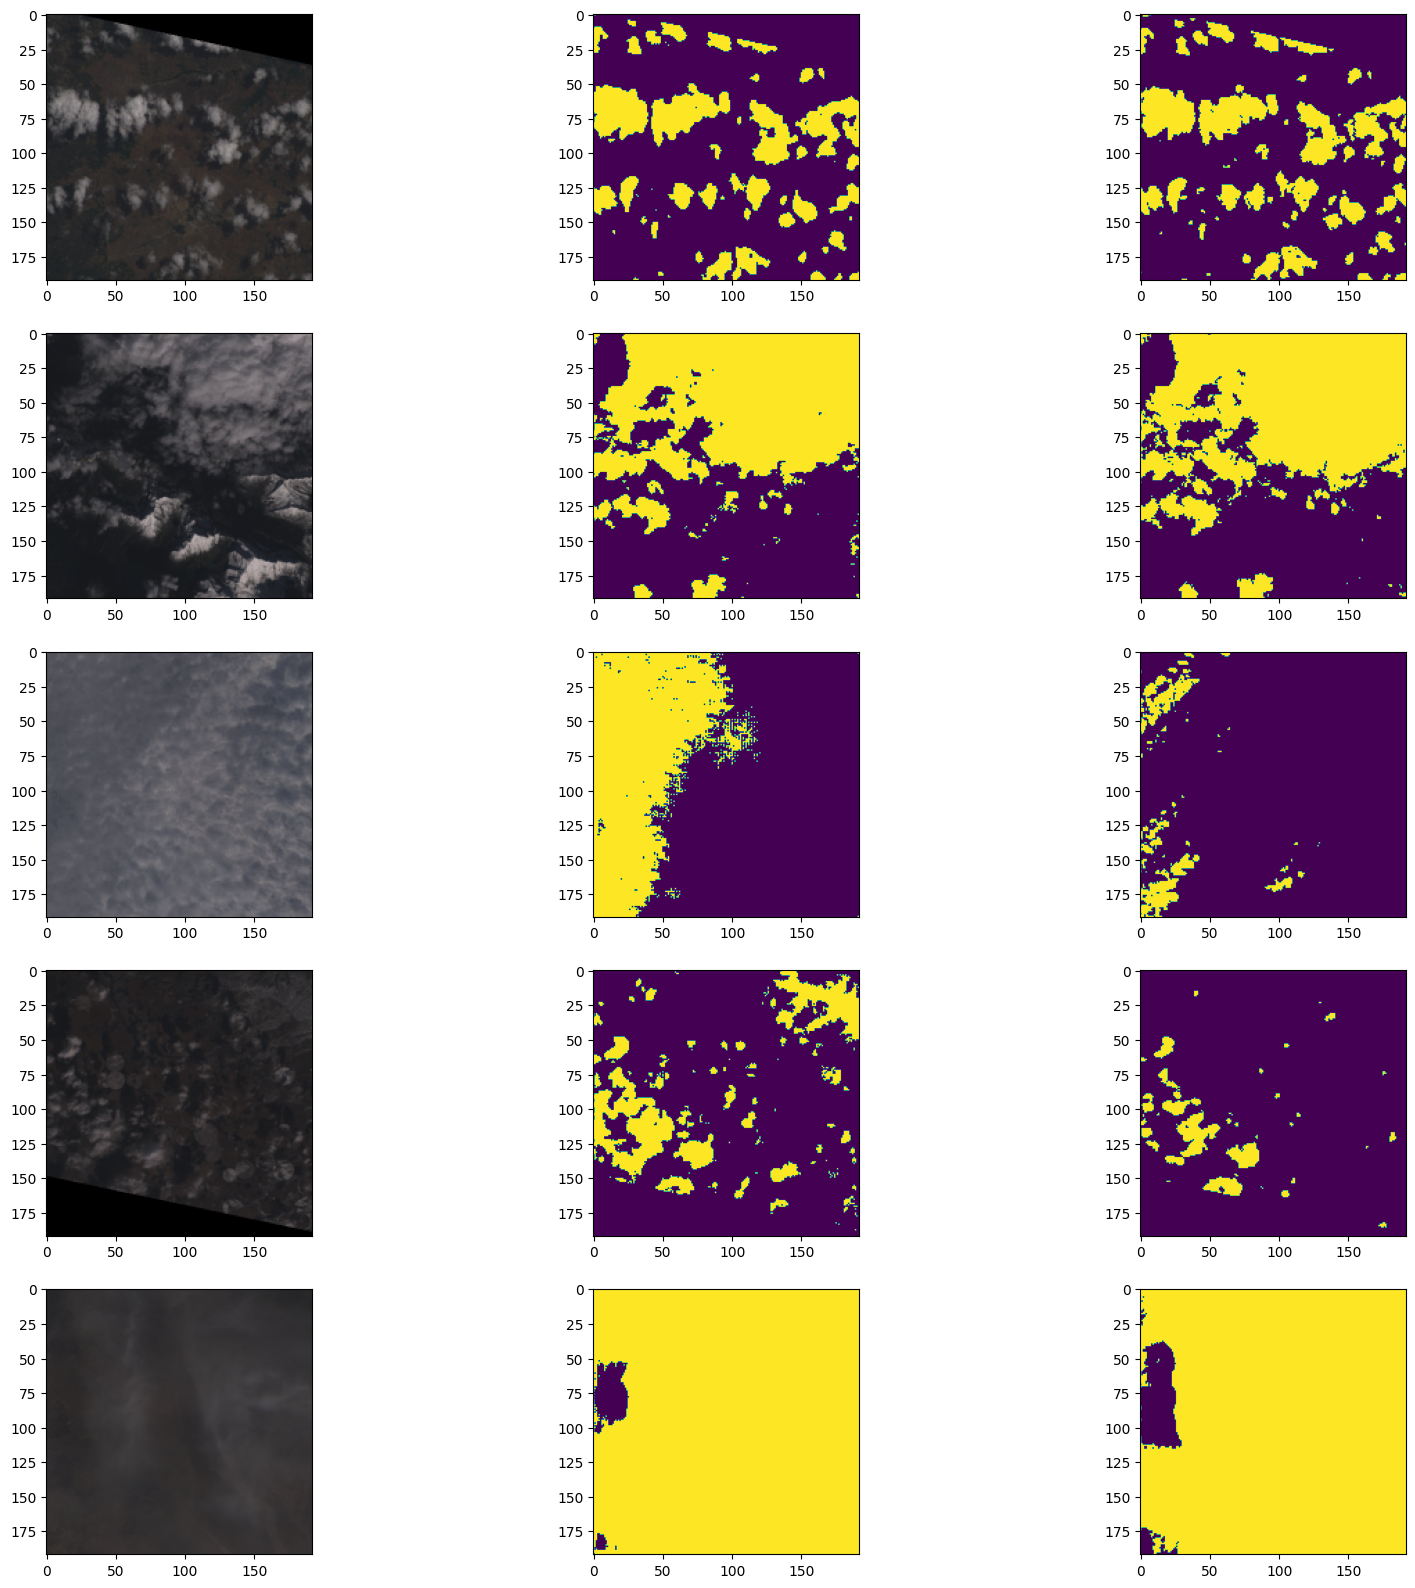

In [17]:
cnt = 0
rows = 5
columns = 3
fig = plt.figure(figsize=(20, 20))

for img, label in dataset.valid_dataset:
    cnt += 1
    image = np.dstack((img[0][1], img[0][2], img[0][3]))
    fig.add_subplot(rows, columns, (cnt-1)*3+1)
    plt.imshow(image)
   
    preds = model(img.cuda())
    preds = (preds > 0.5).float()
    predict = preds[0].swapaxes(0,1)
    predict = predict.swapaxes(1,2)
    fig.add_subplot(rows, columns, (cnt-1)*3+2)
    plt.imshow(predict.cpu().detach().numpy())

    labels = label[0].swapaxes(0,1)
    labels = labels.swapaxes(1,2)
    fig.add_subplot(rows, columns, (cnt-1)*3+3)
    plt.imshow(labels)

    if cnt == 5: break
plt.show()    